## SHRINKAGE METHODS

In [12]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

### usiamo i dati engineered con log-price

In [13]:
data=pd.read_csv("Data/aircraft_price_Engineered.csv")
data.columns

Index(['price', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span',
       'range'],
      dtype='object')

In [14]:
numeric_data=data.select_dtypes(include=[np.number])
numeric_data

,price,roc_mean,speed_margin,power_per_distance,wing_span,range
0,-1.239668,-0.944052,-0.065958,0.659120,-0.224625,-0.778784
1,-1.373907,-0.972572,-0.074822,0.330765,-0.380912,-1.037748
2,-0.736084,-1.064294,0.361711,0.347284,-0.507895,-1.008974
3,-1.239668,-1.063478,0.344232,0.349529,-0.507895,-1.008974
4,-1.334789,-1.090605,0.544989,0.373332,-0.507895,-1.059329
...,...,...,...,...,...,...
502,1.546067,0.471781,1.481530,0.098339,0.976834,1.392196
503,1.219848,0.331523,-0.876044,-0.043328,0.976834,1.166322
504,0.944994,0.704296,-0.946083,-0.044204,0.976834,0.868514
505,0.975122,0.408643,-0.466041,-0.134887,0.390757,0.610988


In [15]:
# Prepare features and target
X = pd.get_dummies(data.drop('price', axis=1), drop_first=True)
y = data['price']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Define lambda values for regularization
lambda_values = np.logspace(-2, 3, 150)

In [16]:
# Create Ridge pipeline with scaling
pipeline = make_pipeline(StandardScaler(), Ridge())

# Grid search for best alpha
param_grid = {'ridge__alpha': lambda_values}
ridge_cv = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=10)
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.best_params_['ridge__alpha']
print(f"Best Ridge alpha: {best_alpha}")

Best Ridge alpha: 16.65238756632532


In [17]:
# Evaluate on test set
ridge_best = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
ridge_best.fit(X_train, y_train)
ridge_pred = ridge_best.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(f"Ridge Test MSE: {ridge_mse:.2f}")

Ridge Test MSE: 0.36


In [18]:
#denormalizza MSE
y_test_denorm = y_test * data['price'].std() + data['price'].mean()
ridge_pred_denorm = ridge_pred * data['price'].std() + data['price'].mean()
ridge_mse_denorm = mean_squared_error(y_test_denorm, ridge_pred_denorm)
print(f"Ridge Test MSE (denormalized): {ridge_mse_denorm:.2f}")

Ridge Test MSE (denormalized): 0.36


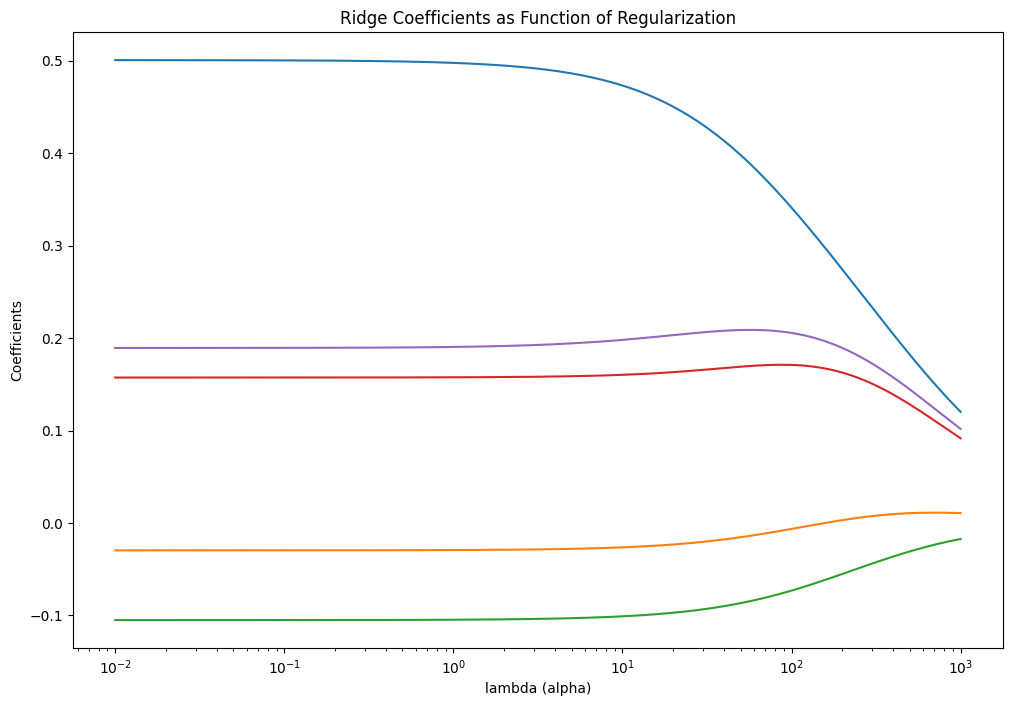

In [19]:
# Plot coefficients vs lambda
coefs = []
for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=a))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['ridge'].coef_)

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(lambda_values, coefs)
ax.set_xscale('log')
plt.xlabel('lambda (alpha)')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients as Function of Regularization')
plt.show()

Stai osservando come Ridge "controlla" i coefficienti al crescere della regolarizzazione: li rende piccoli, ma non li azzera — e questo è esattamente il comportamento previsto.

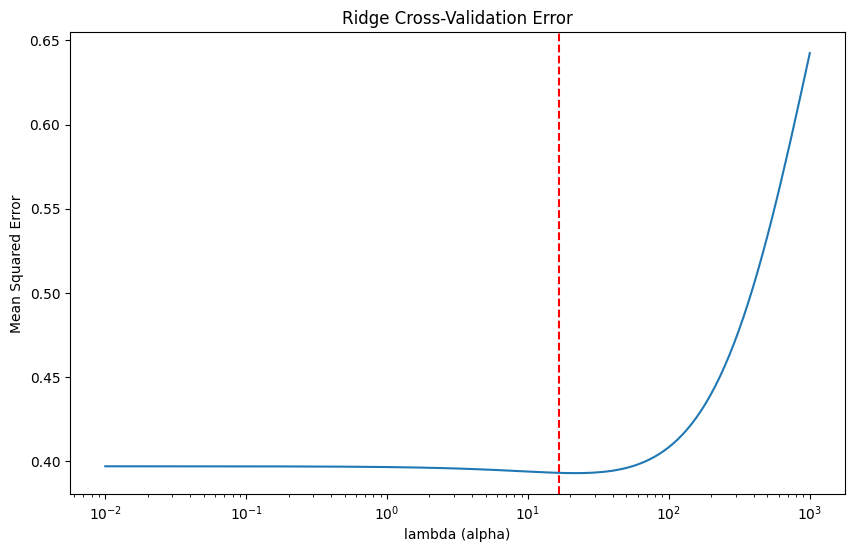

In [20]:
# Plot cross-validation errors
cv_scores = []
for alpha in lambda_values:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = -cross_val_score(pipe, X_train, y_train, cv=kf, 
                             scoring='neg_mean_squared_error')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values, cv_scores)
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel('lambda (alpha)')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Cross-Validation Error')
plt.show()

## LASSO 

In [21]:
# Create Lasso pipeline with scaling
lasso_pipe = make_pipeline(StandardScaler(), Lasso(max_iter=10000))


# Grid search for best alpha
lasso_cv = GridSearchCV(lasso_pipe, 
                       {'lasso__alpha': lambda_values},
                       scoring='neg_mean_squared_error',
                       cv=10)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.best_params_['lasso__alpha']
print(f"Best Lasso alpha: {best_alpha}")

Best Lasso alpha: 0.010803315190764676


In [22]:
# Evaluate on test set
lasso_best = lasso_cv.best_estimator_
lasso_pred = lasso_best.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print(f"Lasso Test MSE: {lasso_mse:.2f}")

# Number of non-zero coefficients
final_coefs = lasso_best.named_steps['lasso'].coef_
print(f"Number of non-zero coefficients: {np.sum(final_coefs != 0)}")

Lasso Test MSE: 0.36
Number of non-zero coefficients: 5


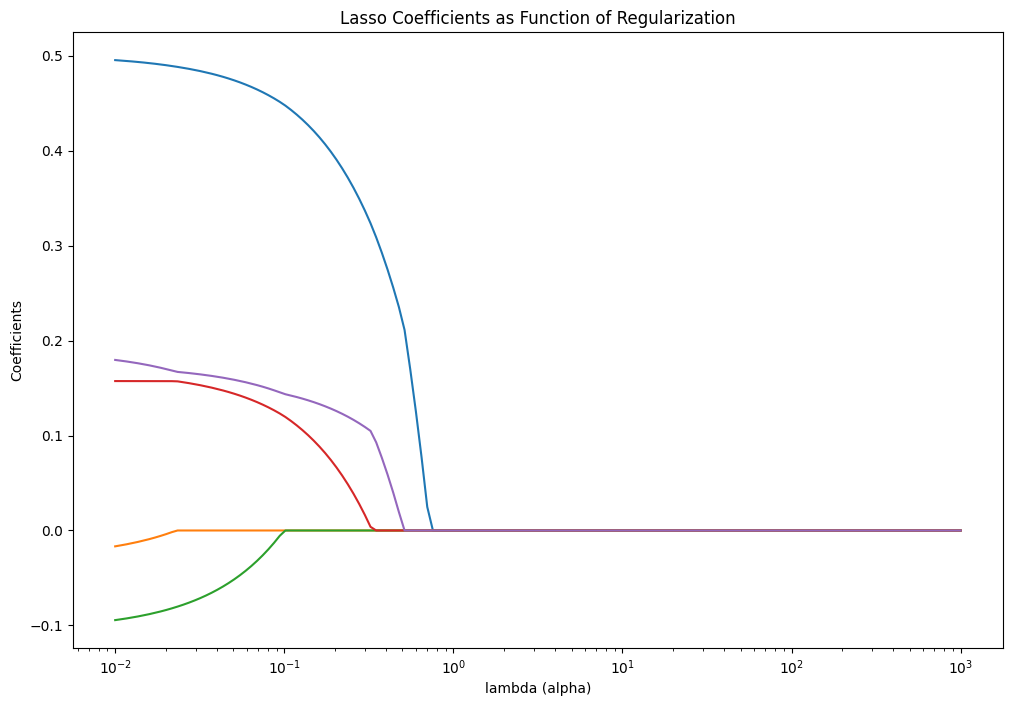

In [23]:
# Plot Lasso coefficients for different lambda values
coefs = []
for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=a, max_iter=10000))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['lasso'].coef_)

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(lambda_values, coefs)
ax.set_xscale('log')
plt.xlabel('lambda (alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as Function of Regularization')
plt.show()